In [8]:
import numpy as np
from utils import kronString, stateToBinary, reverseOrder


""" 
###################################
Qubit ordering: left: highest, right lowest

Example: 01010: 0th qubit is the one at the right

If we want to apply a X gate to the first qubit, we need to apply the gate

I x I x I x X x I

###################################
"""




H1 = 1/np.sqrt(2)*np.array([[1,1],[1,-1]], dtype=complex)
I1= np.array([[1,0],[0,1]],dtype=complex)
X1 = np.array([[0,1],[1,0]])
#projection operators
p0 =  np.array([[1,0],[0,0]],dtype=complex)
p1 = np.array([[0,0],[0,1]],dtype=complex)

def omega(i,j,n):
    return np.exp(2*np.pi*1j/2**n * i*j)

def QFTMatrix(n):
    # n: number of qubits
    N = 2**n
    # create a n x n dimensional np.array with ones in it
    operator = np.ones((N,N), dtype=complex)
    # now fill in the lower right square of the matrix with the powers of omega
    for i in range(1,N):
        for j in range(1,N):
            operator[i,j] = omega(i,j,n)
    # add normalization
    operator = operator*1/(N**0.5)
    return operator

def kronStringPE(string, operator):
    """
    Copy of kronString() from QFT code, changed a little bit for PE application
    Turn a string with single qubit gate instructions into kronecker products. We need to take into account, that the string
    needs to be iterated through backwards, because for example a X gate on the 1st qubit with 5 qubits in total would be
    I x Ix I x X x I.

    Input: string: String with single Qubit names, power: angle for phase gate

    Output: Kronecker product of all input gates, numpy array of shape 2**len(string)
    
    """
    strList = list(string)
    #print(strList)
    strList = strList[::-1]
    if strList[0] == "U":
        prod = operator
    elif strList[0] == "P":
        prod = p0
    elif strList[0] == "Q":
        prod = p1
    else:
        prod = I1
    for matrix in strList[1:]:
        if matrix == "U":
            prod = np.kron(operator,prod)
        elif matrix == "P":
            prod = np.kron(p0,prod)
        elif matrix == "Q":
            prod = np.kron(p1,prod)
        else:
            prod = np.kron(I1,prod)
    return prod

# copy of the CNOT function from the QFT, we can just swap the X with the unitary
def CU(controlling,t,n, operator, printString=False):
    """
    A CNOT gate can be writte as CU,1=|0⟩⟨0|⊗I+|1⟩⟨1|⊗U for example.
    The outer products are at the position of the first index, whereas the X is on the right at the position of the second index.
    another example: CNOT1,3=I⊗|0⟩⟨0|⊗I⊗I+I⊗|1⟩⟨1|⊗I⊗X

    In the PE case, the controlling bit is some different one from the upper register and the controlled one is always the lower register.
    Therefore we just ignor U while creating the upper part for of the gate for the controlling part and then after the loop, add the controlled
    part. Here we take into account, that U might be bigger than 2x2 so we add a number of identities, that matches the qubits needed, for U.
    """
    # create strings for both parts to feed into kronString() function to calculate the products
    part1 = ""; part2 = ""
    """ 
    we need to reverse the controlling index passed from the applyU() function. This is because applyU() gives qubit index 0 for the
    most right qubit in the t register.
    """
    for i in range(t):
        if i == t-1-controlling:
            # p0 = P, p1 = Q, my kron function gets screwed up, because of list(str) for two letter names
            part1 += "P"
            part2 += "Q"
        else:
            part1 += "I" 
            part2 += "I" 
    for i in range(n):
        part1 += "I" 
        part2 += "U" 
    if printString == True:
        print(part1,part2)
    print(f"String for part 1: {part1} and part 2 {part2}")
    gate = kronStringPE(part1, operator) + kronStringPE(part2, operator)
    return gate


def applyHadamards(t,n, state):
    """ 
    Qubit ordering described at the top!

    Hadamard on the 0th qubit (with t=3) would be: I x I x H
    We can easily check if the Hadamard operation is correct, by looking at the binary representation of our state
    after the hadamard gates. The qubits representing the eigenstate, shouldnt have chagned, whereas all the other ones
    should exist as 0 and 1

    """
    # Apply Hadamard gate to all qubits of register t
    for i in range(t):
        # create a hadamard gate string for the qubits in t
        gateStr = ""
        for j in range(t):
            if j == i:
                gateStr = "H" + gateStr
                print(f"Applying Hadamard to {i} qubit")
            else:
                gateStr = "I" + gateStr
        # add identities for the lower register
        for i in range(n):
            gateStr = gateStr + "I" 
        #print(f"Shape of gate: {kronString(gateStr).shape[0]}, shape of state {state.shape[0]}")
        print(f" Gate as string: {gateStr}")
        state = np.matmul(kronString(gateStr), state)

    return state

def applyInverseQFT(t,unitary):
    # first we need to add identites make the QFT matrix bigger and add identitys, so it  can be applied on the full
    # register but leaves the lower register unchanged
    
    finalQFT = np.kron(QFTMatrix(t).conj().T, np.identity(unitary.shape[0]))
    #print("QFT Matrix:")
    #print(np.round(finalQFT,2))
    return finalQFT

def applyU(t,n,state, unitary):
    # for each qubit in the upper register
    for i in range(t):
        # we start with the 0th qubit (most right qubit, befor the n eigenstate qubits)
        # apply U i times: for example. for the t-1th bit we apply U 2^(t-1) times
        print(f"Applying CU gate to qubit {i} with exponent {2**(i)}")
        controlledU = CU(controlling = i, t=t, n =n, operator = unitary)
        for j in range(2**(i)):
            # create the controlled phase gate that puts the phase from U onto the one qubit
            state = np.matmul(controlledU, state)
    return state

def calculatePhase(t,n, unitary, eigenstate):

    # prepare eigenstate in lower register
    upperState = np.zeros(2**t)
    upperState[0] = 1
    state = np.kron(upperState, eigenstate)
    #print(state)
    #print(state)

    print(f"\n Binary state before applying Hadamard\n {stateToBinary(state,t+n)}")
    state = applyHadamards(t,n,state)

    print(f"\n Binary state after applying Hadamard and before U gates\n {stateToBinary(state,t+n)}")
    # Now apply exponentiated U gates to upper register
    state = applyU(t,n,state,unitary)
    print(f"\n Binary state after applying U gates and before QFT\n {stateToBinary(state,t+n)}")
    # now to inverse QFT
    state = np.matmul(applyInverseQFT(t, unitary),state)
    print(f"\n Binary state after applying QFT\n {stateToBinary(state,t+n)}")


    """ 
    Now we need to extract the phases from the final state. This is a bit more complicated because of my choice of representation. I can choose
    between the general state in the 2**(t+n) product space, or I can choose the binary representation. Because you can't really read out of the 
    product space, which qubit is in which state, I will have to use the binary representation. The algorithm for this is following:

    1. Our final state is a super position of many states. So we need to iterate through every binary state.
    2. For each of the state, we calculate the total phase. For example first state: "0 00" where the space
    indicates, where computational and eigenstate register split (remember, that we reversed the qubits at some point, when you look at the output, you see
    that the first qubit (after the reversing order) is always 0, as it should be, because it's the unchanging eigenstate (in the case of a 2x2 Unitary matrix)).
    Here the phase gain is 0. For "0 10" we would have "Eigenstate Phi1 Phi0", so we would have a phase gain of 

    amplitude of this state * 2^-1
    """

    
    # reverse Order because I saw it somewhere?
    state = reverseOrder(state,t+n)
    # tupel representation [("0101", amplitude)]
    # convert state into binary
    binaryState = stateToBinary(state, t+n)
    binaryCombinations = [tup[0] for tup in binaryState]
    amplitudes =  [tup[1] for tup in binaryState]
    phase = 0
    # 1. iterate through all the states
    for combination in binaryCombinations:
        # transfer it into list of integers
        combinationint = [int(i) for i in combination]
        print(combination)
        # the first n qubits are reserved for the eigenstate
        for i in range(n,t+n):
            # the most left qubit (after n, remember we have) gets 1 as a factor, the second right gets 0.5 and so on
            # we are going from left to right, so we have start with the biggest fraction. First one is 2**(-(t-1))
            # add prints again to check
            if combinationint[i] == 1:
                print(2**(-1*(t-1+n-i)))
                phase += amplitudes[binaryCombinations.index(combination)]*2**(-1*(t-i+1))

    return phase

def phaseEstimation(unitary):

    # calculate to be estimated values
    eigenvalues, eigenstates = np.linalg.eig(unitary)
    
    # convert eigenvalues to phases
    eigenvalues = np.log(eigenvalues) / (2*np.pi*1j)
    # make eigenvalues positiv
    for i in range(len(eigenvalues)):
        if eigenvalues[i] < 0:
            eigenvalues[i] += 1
    print(f"Eigenstate: {eigenstates[0]}")
    t = 3
    n = int(np.log2(unitary.shape[0]))
    phase = calculatePhase(t,n, unitary, eigenstates[0])


    print(f"To be evaluated eigenvalue: {eigenvalues[0]}")
    print(f"Estimated eigenvalue: {phase} with {t} qubits of precision.")


unitary = np.array([[np.e**(2*np.pi*1j*0.0625),0],[0,1]])

phaseEstimation(unitary)

Eigenstate: [1.+0.j 0.+0.j]

 Binary state before applying Hadamard
 [('0000', (1+0j))]
Applying Hadamard to 0 qubit
 Gate as string: IIHI
Applying Hadamard to 1 qubit
 Gate as string: IHII
Applying Hadamard to 2 qubit
 Gate as string: HIII

 Binary state after applying Hadamard and before U gates
 [('0000', (0.3535533905932737+0j)), ('0010', (0.3535533905932737+0j)), ('0100', (0.3535533905932737+0j)), ('0110', (0.3535533905932737+0j)), ('1000', (0.3535533905932737+0j)), ('1010', (0.3535533905932737+0j)), ('1100', (0.3535533905932737+0j)), ('1110', (0.3535533905932737+0j))]
Applying CU gate to qubit 0 with exponent 1
String for part 1: IIPI and part 2 IIQU
Applying CU gate to qubit 1 with exponent 2
String for part 1: IPII and part 2 IQIU
Applying CU gate to qubit 2 with exponent 4
String for part 1: PIII and part 2 QIIU

 Binary state after applying U gates and before QFT
 [('0000', (0.3535533905932737+0j)), ('0010', (0.32664074121909403+0.13529902503654923j)), ('0100', (0.24999999999

So the above python cell is quite thorough on outputs, because the phase estimation does not always work. But sometimes it works. So instead of spending more time on trouble shooting I rather go into coding something else again and I will try to evaluate how often or how well my phase estimation works. With this at least I can train some plotting skills. The idea is to do the phase
estimation for some random eigenvalues of a 2x2 matrix for different qubit numbers and compare, how the error behaves.

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from PEutils import phaseEstimation
import time
from tqdm import tqdm


tList = [2,3,4,5,6,7,8]

numExperiments = 1000
errors = []

# for each number of computational qubits
for t in tqdm(tList):
    # do several experiments aka random matrix to be evaluated
    averageError = []
    minError = 1000
    threshold = 0.05
    goodGuess = 0
    for i in range(numExperiments):
        randomPhase = np.random.rand()
        unitary = np.array([[np.exp(2*np.pi*1j*randomPhase),0],[0,1]])
        expected , estimated = phaseEstimation(t,unitary)
        error = np.abs(expected-estimated)
        if error < minError:
            minError = error
        if error < threshold:
            goodGuess += 1



        averageError.append(error)
    print(f"Minimum error for t = {t} is {minError}")
    print(f"propability for a good guess is approximately {goodGuess/numExperiments * 100}%")
    errors.append(np.sum(averageError)/numExperiments)




 14%|█▍        | 1/7 [00:00<00:03,  1.78it/s]

Minimum error for t = 2 is 0.00011594308192504014
propability for a good guess is approximately 10.6%


 29%|██▊       | 2/7 [00:01<00:05,  1.00s/it]

Minimum error for t = 3 is 0.0007337274345586461
propability for a good guess is approximately 10.9%


 43%|████▎     | 3/7 [00:04<00:06,  1.57s/it]

Minimum error for t = 4 is 0.000980540572016352
propability for a good guess is approximately 9.8%


 57%|█████▋    | 4/7 [00:11<00:11,  3.78s/it]

Minimum error for t = 5 is 0.0004983000172757592
propability for a good guess is approximately 11.0%


 71%|███████▏  | 5/7 [00:29<00:17,  8.88s/it]

Minimum error for t = 6 is 0.0003506135981792534
propability for a good guess is approximately 9.9%


 86%|████████▌ | 6/7 [02:21<00:44, 44.03s/it]

Minimum error for t = 7 is 0.00043935985603418945
propability for a good guess is approximately 11.3%


100%|██████████| 7/7 [10:30<00:00, 90.08s/it] 

Minimum error for t = 8 is 9.426868316517495e-06
propability for a good guess is approximately 11.600000000000001%


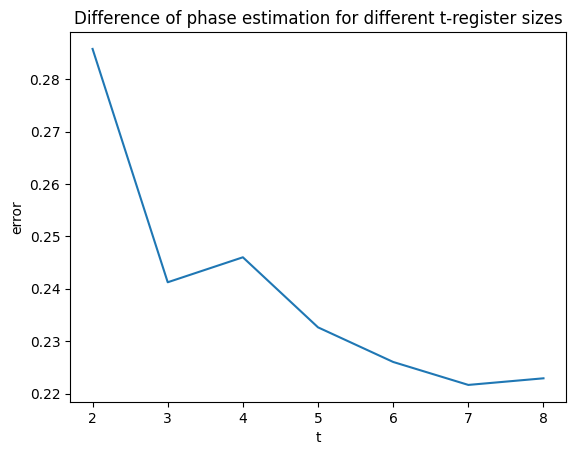

In [3]:
plt.plot(tList,errors)
plt.title("Difference of phase estimation for different t-register sizes")
plt.xlabel("t")
plt.ylabel("error")
plt.savefig("PEresult1.png")

In [4]:
state = np.array([1,0,0,0,0,0,0,0])
n = 3
state1 = np.matmul(np.kron(I1,np.kron(I1,H1)),state)
state2 = np.matmul(kronString("IIH"), state)
print(stateToBinary(state1,n))
print(stateToBinary(state2,n))

[('000', (0.7071067811865475+0j)), ('001', (0.7071067811865475+0j))]
[('000', (0.7071067811865475+0j)), ('001', (0.7071067811865475+0j))]


In [5]:
state1 = np.array([1,0,0,0])
state2 = np.array([0,1])
state = np.kron(state1, state2)
print(stateToBinary(state1,2), stateToBinary(state2,1), stateToBinary(state,3))

[('00', 1)] [('1', 1)] [('001', 1)]


In [6]:
# the phase is the amplitude of each bit times 2^-position of bit 
    phase = 0
    # skip the first n qubits, because they belong to the eigenstate
    for i in range(n,t+n):
        print(f" n: {n}, i: {i}, i-n {i-n}")
        # get the string of the binary representation i.e. "00101"
        binary = binaryState[i]
        binaryList = list(binary[0])
        binaryList = [int(i) for i in binaryList]
        print(binaryList[i-n])
        if binaryList[i-n] == 1:
            print(i-n)
            phase += binaryState[i][1] * 2**(-i-n)

IndentationError: unexpected indent (3716968658.py, line 2)